In [19]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle
import model

In this notebook we will be looking at the prediction problem through the lense of a classification modeling problem.  To tackle this problem we will be taking a few different approaches.

- Treating the quality score as a category
- Treating quality scores 7, 8, and 9 as a "good wine" category
- Treating quality scores less than 5 as a "bad wines" category


In [20]:
r = wrangle.wrangle_data('red')
tr, sr, vr = helpers.prep.train_test_validate_split(r)

In [21]:
w = wrangle.wrangle_data('white')
tw, sw, vw = helpers.prep.train_test_validate_split(w)

In [22]:
frames = [tr, sr, vr, tw, sw, vw]
reds = [tr, sr, vr]
whites = [tw, sw, vw]

### Clusters

In [23]:
rclst = model.FlavorProfile()
rclst.fit(tr)
tr['flavor_profile'] = rclst.predict(tr)
sr['flavor_profile'] = rclst.predict(sr)
vr['flavor_profile'] = rclst.predict(vr)
wclst = model.FlavorProfile()
wclst.fit(tw)
tw['flavor_profile'] = rclst.predict(tw)
sw['flavor_profile'] = rclst.predict(sw)
vw['flavor_profile'] = rclst.predict(vw)

### Vinegar categories


In [24]:
bins = [-np.inf, 0.6, 1.2, np.inf]
labels = ['undetectable','noticeable','strong']

for df in frames:
    df['flavor_vinegar'] = pd.cut(df.volatile_acidity, bins=bins, labels=labels)

### One hot encoding pipeline

In [25]:
target = 'quality'
cat_feats = [
    'flavor_profile',
    # 'flavor_vinegar',
]
num_feats = [
    'fixed_acidity', 
    'volatile_acidity', 
    'citric_acid', 
    'residual_sugar',
    'chlorides', 
    'free_sulfur_dioxide', 
    # 'total_sulfur_dioxide', 
    # 'density',
    # 'ph', 
    'sulphates', 
    'alcohol',
]

In [26]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(tr[cat_feats])
temp = encoder.transform(tr[cat_feats])

In [27]:
def train_onehot_encoder(df, cats):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(df[cats])
    return encoder

In [28]:
temp.todense()

matrix([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [29]:
encoder.get_feature_names_out()

array(['flavor_profile_0', 'flavor_profile_1', 'flavor_profile_2',
       'flavor_profile_3'], dtype=object)

In [30]:
cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
cats

,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
810,0.0,0.0,1.0,0.0
811,1.0,0.0,0.0,0.0
812,0.0,1.0,0.0,0.0
813,1.0,0.0,0.0,0.0


In [31]:
tr.index

Int64Index([  38,   54,  138,  779, 1559,  248,  261,  908,  640,  389,
            ...
             127,  970, 1302,   52, 1000,  152, 1156,  149,  413,  518],
           dtype='int64', length=815)

In [32]:
xf = pd.concat([tr[num_feats], cats.set_index(tr.index)], axis=1)

In [33]:
scaler = helpers.prep.train_scaler(xf)

xf = helpers.prep.scale_df(xf, scaler)

In [34]:
xf.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,sulphates,alcohol,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3
38,0.089286,0.829060,0.09,0.041096,0.239168,0.084507,0.067485,0.215385,0.0,0.0,1.0,0.0
54,0.258929,0.299145,0.15,0.130137,0.131716,0.450704,0.159509,0.276923,0.0,1.0,0.0,0.0
138,0.276786,0.341880,0.19,0.082192,0.081456,0.197183,0.104294,0.169231,0.0,1.0,0.0,0.0
779,0.214286,0.307692,0.03,0.116438,0.072790,0.281690,0.141104,0.215385,0.0,1.0,0.0,0.0
1559,0.276786,0.376068,0.26,0.075342,0.079723,0.422535,0.092025,0.230769,0.0,0.0,1.0,0.0


In [35]:
config_obj = {
    'target' : target,
    'cat_feats' : cat_feats,
    'num_feats' : num_feats
}

def prep_frame(df, encoder, scaler, config):
    '''Converts a raw dataframe to a dictionary with model ready 'X' and 'y' variables.
    '''
    target = config['target']
    cat_feats = config['cat_feats']
    num_feats = config['num_feats']
    
    y = df[target]

    temp = encoder.transform(df[cat_feats])
    cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
    xf = pd.concat([df[num_feats], cats.set_index(df.index)], axis=1)

    xf = helpers.prep.scale_df(xf, scaler)

    out = {
        'X' : xf,
        'y' : y
    }

    return out

In [36]:
d = prep_frame(tr, encoder, scaler, config_obj)
d['X']

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,sulphates,alcohol,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3
38,0.089286,0.829060,0.09,0.041096,0.239168,0.084507,0.067485,0.215385,0.0,0.0,1.0,0.0
54,0.258929,0.299145,0.15,0.130137,0.131716,0.450704,0.159509,0.276923,0.0,1.0,0.0,0.0
138,0.276786,0.341880,0.19,0.082192,0.081456,0.197183,0.104294,0.169231,0.0,1.0,0.0,0.0
779,0.214286,0.307692,0.03,0.116438,0.072790,0.281690,0.141104,0.215385,0.0,1.0,0.0,0.0
1559,0.276786,0.376068,0.26,0.075342,0.079723,0.422535,0.092025,0.230769,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.250000,0.376068,0.03,0.061644,0.105719,0.338028,0.104294,0.261538,0.0,0.0,1.0,0.0
1156,0.339286,0.017094,0.51,0.058219,0.064125,0.619718,0.239264,0.523077,1.0,0.0,0.0,0.0
149,0.312500,0.205128,0.44,0.130137,0.095321,0.140845,0.147239,0.323077,0.0,1.0,0.0,0.0
413,0.464286,0.205128,0.53,0.397260,0.109185,0.070423,0.276074,0.507692,1.0,0.0,0.0,0.0


In [37]:
v = prep_frame(vr, encoder, scaler, config_obj)

# Red wine modeling

### Red Fitting pipeline

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from helpers.eval import BaselineModel

models = {
    "Mode" : BaselineModel(method='mode'),
    # "KNN - 3": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": SVC(C=0.025, kernel="linear"),
    "RBF SVM": SVC(C=1, gamma=2),
    "Gaussian Process": GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    # "Decision Tree": DecisionTreeClassifier(max_depth=5),
    # "Random Forest": RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
    # "XG Boost": XGBClassifier(),
    # "XGRF": XGBRFClassifier(),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis(),
    }

In [39]:
for k in range(1,16):
    models[f"KNN_{k}"] = KNeighborsClassifier(n_neighbors=k)
for k in range(1,16):
    models[f'Decision Tree_{k}'] = DecisionTreeClassifier(max_depth=k)
for k in range(1,16):
    models[f"Random Forest_{k}"] = RandomForestClassifier(max_depth=k)

In [40]:
import time
for name, model in models.items():
    # time.sleep(1)
    start_time = time.time()
    model.fit(d['X'], d['y'])
    stop_time = time.time()
    print(f'Fit {name} in {stop_time-start_time}')

Fit Mode in 0.00299835205078125
Fit Logistic Regression in 0.05700230598449707
Fit Linear SVM in 0.025997638702392578
Fit RBF SVM in 0.06200551986694336
Fit Gaussian Process in 52.531593322753906
Fit Neural Net in 0.9081058502197266
Fit AdaBoost in 0.1266171932220459
Fit Naive Bayes in 0.0030007362365722656
Fit KNN_1 in 0.005707979202270508
Fit KNN_2 in 0.003998517990112305
Fit KNN_3 in 0.004000425338745117
Fit KNN_4 in 0.003998994827270508
Fit KNN_5 in 0.0030002593994140625
Fit KNN_6 in 0.0029997825622558594
Fit KNN_7 in 0.00400090217590332
Fit KNN_8 in 0.004001140594482422
Fit KNN_9 in 0.0029981136322021484
Fit KNN_10 in 0.0030031204223632812
Fit KNN_11 in 0.0029969215393066406
Fit KNN_12 in 0.0050013065338134766
Fit KNN_13 in 0.002998828887939453
Fit KNN_14 in 0.0030007362365722656
Fit KNN_15 in 0.003998994827270508
Fit Decision Tree_1 in 0.0020017623901367188
Fit Decision Tree_2 in 0.0030012130737304688
Fit Decision Tree_3 in 0.0029990673065185547
Fit Decision Tree_4 in 0.003000020

### Red Scoring

In [41]:
from sklearn.metrics import accuracy_score, mean_squared_error, max_error
scores = {}
for name, model in models.items():
    # time.sleep(1)
    start_time = time.time()
    tp = model.predict(d['X'])
    vp = model.predict(v['X'])
    scores[f'red_{name}'] = {
        'train_acc': accuracy_score(d['y'], tp),
        'validate_acc': accuracy_score(v['y'], vp),
        'train_rmse' : mean_squared_error(d['y'], tp, squared=False),
        'validate_rmse' : mean_squared_error(v['y'], vp, squared=False),
        'train_max_error': max_error(d['y'], tp),
        'validate_max_error': max_error(v['y'], vp),
        'tp': tp,
        'vp': vp
    }
    stop_time = time.time()
    print(f'{name} predicted in {stop_time-start_time}')

Mode predicted in 0.0019996166229248047
Logistic Regression predicted in 0.005002260208129883
Linear SVM predicted in 0.028997182846069336
RBF SVM predicted in 0.1100008487701416
Gaussian Process predicted in 0.9190113544464111
Neural Net predicted in 0.0060002803802490234
AdaBoost predicted in 0.04399728775024414
Naive Bayes predicted in 0.005002498626708984
KNN_1 predicted in 0.06502366065979004
KNN_2 predicted in 0.06651711463928223
KNN_3 predicted in 0.07252144813537598
KNN_4 predicted in 0.07131767272949219
KNN_5 predicted in 0.07190752029418945
KNN_6 predicted in 0.0735311508178711
KNN_7 predicted in 0.07625007629394531
KNN_8 predicted in 0.07429981231689453
KNN_9 predicted in 0.07751846313476562
KNN_10 predicted in 0.0750126838684082
KNN_11 predicted in 0.07751989364624023
KNN_12 predicted in 0.08199954032897949
KNN_13 predicted in 0.07401108741760254
KNN_14 predicted in 0.0744636058807373
KNN_15 predicted in 0.07851433753967285
Decision Tree_1 predicted in 0.003997802734375
Dec

In [42]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.shape

(53, 8)

In [43]:
scores_df.sort_values('validate_rmse', ascending=True)

,train_acc,validate_acc,train_rmse,validate_rmse,train_max_error,validate_max_error,tp,vp
red_Random Forest_12,0.995092,0.613971,0.092677,0.727607,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_6,0.753374,0.599265,0.589270,0.730129,3,2,"[4, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_7,0.814724,0.606618,0.501531,0.732642,2,2,"[4, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_8,0.860123,0.591912,0.429009,0.735147,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_13,0.997546,0.599265,0.078326,0.737643,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_11,0.990184,0.595588,0.116176,0.740131,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_9,0.922699,0.625000,0.326724,0.740131,2,3,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 7, ..."
red_Random Forest_4,0.636810,0.580882,0.688200,0.742611,2,2,"[5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_10,0.963190,0.599265,0.210171,0.745082,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_15,1.000000,0.595588,0.000000,0.747545,0,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."


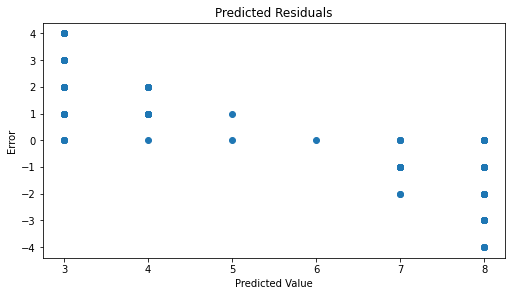

In [44]:
how = scores_df.loc['red_Naive Bayes','tp']
helpers.eval.plot_residuals(d['y'], how)

# White modeling

### White preping

In [45]:
enc_w = helpers.prep.train_onehot_encoder(tw, config_obj['cat_feats'])


In [46]:
def onehot_encode_frame(df, feats, encoder):
    temp = encoder.transform(df[feats])
    cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
    xf = pd.concat([df.drop(columns=feats), cats.set_index(df.index)], axis=1)
    return xf


In [53]:
temp = onehot_encode_frame(tw, config_obj['cat_feats'], enc_w)

In [51]:
temp.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,flavor_vinegar,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3
1327,6.8,0.26,0.33,1.5,0.047,44.0,167.0,0.99280,3.12,0.44,10.5,undetectable,0.0,1.0,0.0,0.0
622,5.3,0.32,0.12,6.6,0.043,22.0,141.0,0.99370,3.36,0.60,10.4,undetectable,0.0,1.0,0.0,0.0
4737,6.1,0.24,0.32,9.0,0.031,41.0,134.0,0.99234,3.25,0.26,12.3,undetectable,1.0,0.0,0.0,0.0
3503,6.9,0.33,0.31,4.2,0.040,21.0,93.0,0.98960,3.18,0.48,13.4,undetectable,1.0,0.0,0.0,0.0
4239,5.7,0.28,0.36,1.8,0.041,38.0,90.0,0.99002,3.27,0.98,11.9,undetectable,1.0,0.0,0.0,0.0


In [59]:
config_obj['num_feats'] + enc_w.get_feature_names_out().tolist()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'sulphates',
 'alcohol',
 'flavor_profile_0',
 'flavor_profile_1',
 'flavor_profile_2',
 'flavor_profile_3']

In [60]:
temp = temp[config_obj['num_feats'] + enc_w.get_feature_names_out().tolist()]

In [61]:
scale_w = helpers.prep.train_scaler(temp)

In [63]:
m_tw = prep_frame(tw, enc_w, scale_w, config_obj)
m_vw = prep_frame(vw, enc_w, scale_w, config_obj)

### White training

In [64]:
models_w = {
    "Mode" : BaselineModel(method='mode'),
    # "KNN - 3": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": SVC(C=0.025, kernel="linear"),
    "RBF SVM": SVC(C=1, gamma=2),
    # "Gaussian Process": GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    # "Decision Tree": DecisionTreeClassifier(max_depth=5),
    # "Random Forest": RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
    # "XG Boost": XGBClassifier(),
    # "XGRF": XGBRFClassifier(),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis(),
    }

for k in range(1,16):
    models_w[f"KNN_{k}"] = KNeighborsClassifier(n_neighbors=k)
for k in range(1,16):
    models_w[f'Decision Tree_{k}'] = DecisionTreeClassifier(max_depth=k)
for k in range(1,16):
    models_w[f"Random Forest_{k}"] = RandomForestClassifier(max_depth=k)

In [65]:
import time
for name, model in models_w.items():
    # time.sleep(1)
    start_time = time.time()
    model.fit(m_tw['X'], m_tw['y'])
    stop_time = time.time()
    # print(f'Fit {name} in {stop_time-start_time}')

### White scoring

In [66]:
m_tw['X'].columns , d['X'].columns

(Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
        'chlorides', 'free_sulfur_dioxide', 'sulphates', 'alcohol',
        'flavor_profile_0', 'flavor_profile_1', 'flavor_profile_2',
        'flavor_profile_3'],
       dtype='object'),
 Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
        'chlorides', 'free_sulfur_dioxide', 'sulphates', 'alcohol',
        'flavor_profile_0', 'flavor_profile_1', 'flavor_profile_2',
        'flavor_profile_3'],
       dtype='object'))

In [67]:
from sklearn.metrics import accuracy_score, mean_squared_error, max_error
scores = {}
for name, model in models_w.items():
    # time.sleep(1)
    start_time = time.time()
    tp = model.predict(m_tw['X'])
    vp = model.predict(m_vw['X'])
    scores[f'white_{name}'] = {
        'train_acc': accuracy_score(m_tw['y'], tp),
        'validate_acc': accuracy_score(m_vw['y'], vp),
        'train_rmse' : mean_squared_error(m_tw['y'], tp, squared=False),
        'validate_rmse' : mean_squared_error(m_vw['y'], vp, squared=False),
        'train_max_error': max_error(m_tw['y'], tp),
        'validate_max_error': max_error(m_vw['y'], vp),
        'tp': tp,
        'vp': vp
    }
    stop_time = time.time()
    # print(f'{name} predicted in {stop_time-start_time}')

In [68]:
scores_df_w = pd.DataFrame.from_dict(scores, orient='index')
scores_df_w.shape

(52, 8)

In [69]:
scores_df_w.sort_values('validate_rmse', ascending=True)

,train_acc,validate_acc,train_rmse,validate_rmse,train_max_error,validate_max_error,tp,vp
white_Random Forest_12,0.921717,0.561160,0.364110,0.779627,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_9,0.762626,0.558638,0.601275,0.786070,3,3,"[6, 6, 7, 7, 7, 6, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, ..."
white_Random Forest_10,0.827441,0.561160,0.526247,0.786872,3,3,"[6, 6, 7, 7, 7, 5, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_11,0.883418,0.559899,0.432283,0.786872,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_15,0.993687,0.554855,0.100504,0.788473,2,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, ..."
white_Random Forest_13,0.958333,0.554855,0.276004,0.788473,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_8,0.713805,0.558638,0.659686,0.790071,3,3,"[6, 6, 7, 7, 6, 6, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_14,0.979798,0.554855,0.186903,0.790868,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, ..."
white_Random Forest_7,0.663721,0.558638,0.712444,0.794845,3,3,"[6, 6, 7, 7, 6, 6, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, ..."
white_Random Forest_5,0.593434,0.563682,0.767062,0.796430,3,3,"[6, 6, 7, 6, 6, 5, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
